In [1]:
#importing required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
#2. Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [4]:
liesons=['akiec','bcc','bkl','nv','df','mel','vasc']
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
#set image path in variables
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


In [6]:
#read the dataset
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(image_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


In [7]:
#add the images from the path to dataset
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


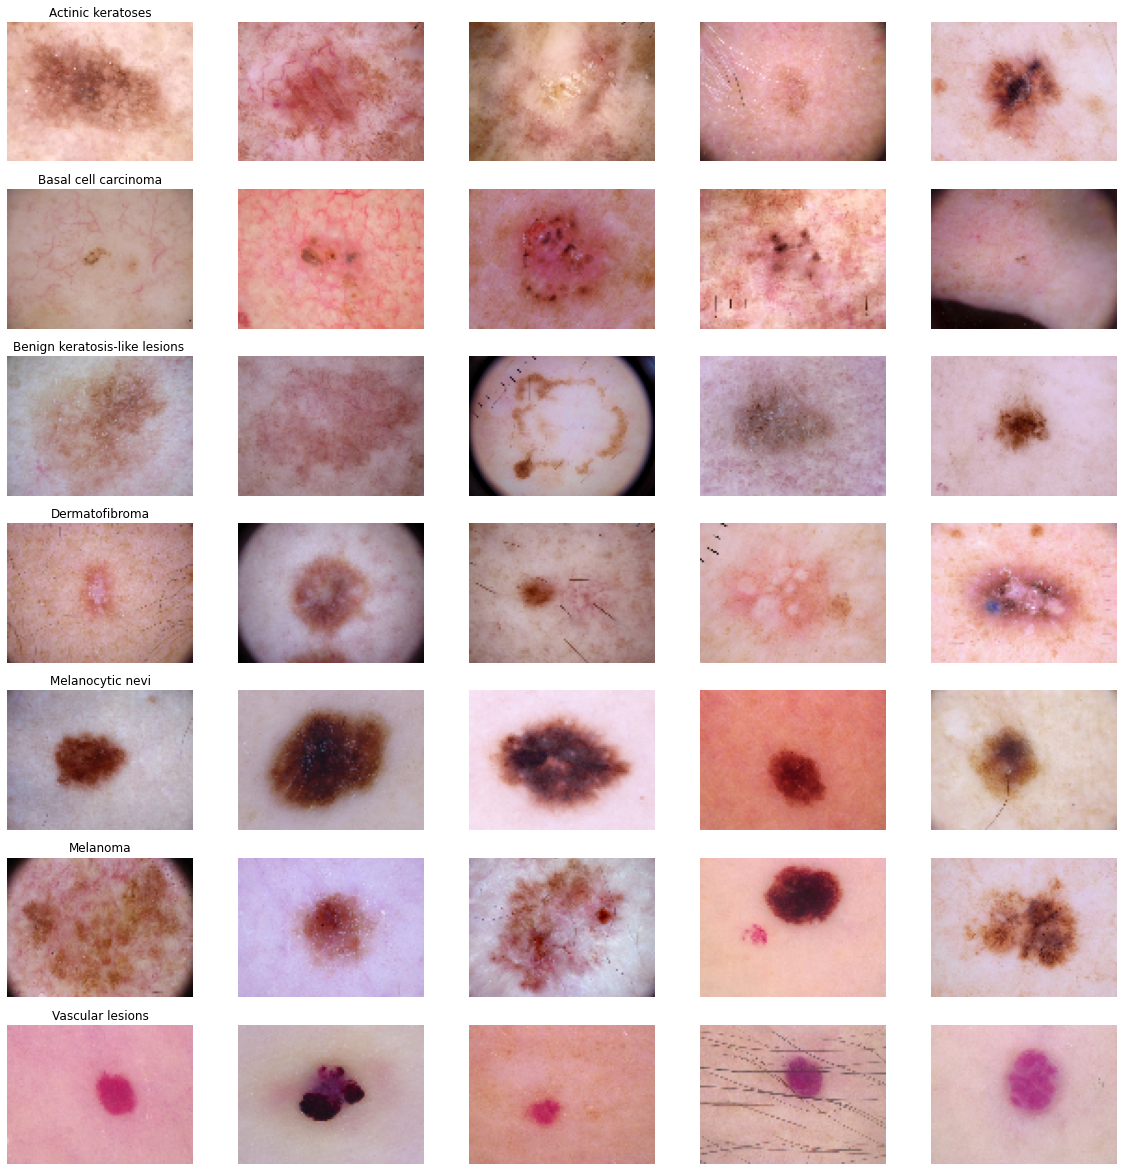

In [9]:
#view some data samples
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=0).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [10]:
#view the shape of the data
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [11]:
#Train Test Split
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=0)

In [12]:
#find missing values
print("x_train:\n",x_train_o.isnull().sum())
print("\nx_test:\n",x_test_o.isnull().sum())

x_train:
 lesion_id        0
image_id         0
dx               0
dx_type          0
age             49
sex              0
localization     0
path             0
cell_type        0
image            0
dtype: int64

x_test:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             8
sex             0
localization    0
path            0
cell_type       0
image           0
dtype: int64


In [13]:
#impute missing values
x_train_o['age'].fillna((x_train_o['age'].mean()), inplace=True)
x_test_o['age'].fillna((x_test_o['age'].mean()), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [14]:
#Normalization
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [15]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o)
y_test = to_categorical(y_test_o)

In [16]:
print(y_train.shape)

(8012, 7)


In [17]:
#Splitting training and validation split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [18]:
print(y_train.shape)

(7210, 7)


In [19]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# CNN

In [20]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu] -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 25, 128)      

In [21]:
#compiling the model with adam optimizer
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.5, min_lr=0.00001)

In [23]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [24]:
# Fit the model
epochs = 50 
batch_size = 10
cnn_history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/50
721/721 [==============================] - 20s 28ms/step - loss: 1.0104 - accuracy: 0.6631 - val_loss: 0.9630 - val_accuracy: 0.6758
Epoch 2/50
 15/721 [..............................] - ETA: 8s - loss: 0.9055 - accuracy: 0.6467

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


721/721 [==============================] - 15s 21ms/step - loss: 0.9050 - accuracy: 0.6764 - val_loss: 0.9049 - val_accuracy: 0.6883
Epoch 3/50
721/721 [==============================] - 16s 22ms/step - loss: 0.8806 - accuracy: 0.6818 - val_loss: 0.8746 - val_accuracy: 0.6895
Epoch 4/50
721/721 [==============================] - 16s 23ms/step - loss: 0.8473 - accuracy: 0.6868 - val_loss: 0.8137 - val_accuracy: 0.7219
Epoch 5/50
721/721 [==============================] - 16s 22ms/step - loss: 0.8183 - accuracy: 0.6967 - val_loss: 0.7953 - val_accuracy: 0.7045
Epoch 6/50
721/721 [==============================] - 16s 22ms/step - loss: 0.8017 - accuracy: 0.7044 - val_loss: 0.7876 - val_accuracy: 0.7319
Epoch 7/50
721/721 [==============================] - 16s 22ms/step - loss: 0.7779 - accuracy: 0.7125 - val_loss: 0.7812 - val_accuracy: 0.7431
Epoch 8/50
721/721 [==============================] - 16s 22ms/step - loss: 0.7670 - accuracy: 0.7250 - val_loss: 0.8481 - val_accuracy: 0.6858
Epo

In [25]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

802/802 [==============================] - 0s 171us/step
Validation: accuracy = 0.758105  ;  loss_v = 0.682551
Test: accuracy = 0.761358  ;  loss = 0.698722


# ANN

In [26]:
#generatingthemodel
ann_model=Sequential()
ann_model.add(Flatten())
#firstlayerwith500neuronsandreluactivationfunction
ann_model.add(Dense(500,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="relu"))
#secondlayerwith500neuronsandreluactivationfunction
ann_model.add(Dense(500,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="relu"))
#thirdlayerwith500neuronsandreluactivationfunction
ann_model.add(Dense(500,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="relu"))
#fourthlayerwith500neuronsandreluactivationfunction
ann_model.add(Dense(500,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="relu"))
#fifthlayerwith500neuronsandreluactivationfunction
ann_model.add(Dense(500,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="relu"))
#outputsoftmaxlayer
ann_model.add(Dense(7,kernel_initializer="glorot_normal",
bias_initializer="glorot_normal",activation="softmax"))

ann_model.compile(loss="categorical_crossentropy",
optimizer="adam",
metrics=["accuracy"])

ann_history=ann_model.fit(x_train,y_train,epochs=25,batch_size=20,validation_data = (x_validate,y_validate),verbose = 1)



Train on 7210 samples, validate on 802 samples
Epoch 1/25
7210/7210 [==============================] - 3s 481us/step - loss: 1.1840 - accuracy: 0.6515 - val_loss: 1.0038 - val_accuracy: 0.6696
Epoch 2/25
7210/7210 [==============================] - 3s 453us/step - loss: 0.9368 - accuracy: 0.6831 - val_loss: 0.9398 - val_accuracy: 0.6783
Epoch 3/25
7210/7210 [==============================] - 3s 427us/step - loss: 0.8800 - accuracy: 0.6913 - val_loss: 0.8680 - val_accuracy: 0.6933
Epoch 4/25
7210/7210 [==============================] - 3s 424us/step - loss: 0.8407 - accuracy: 0.7060 - val_loss: 0.8219 - val_accuracy: 0.7107
Epoch 5/25
7210/7210 [==============================] - 3s 422us/step - loss: 0.8084 - accuracy: 0.7108 - val_loss: 0.9050 - val_accuracy: 0.6895
Epoch 6/25
7210/7210 [==============================] - 3s 441us/step - loss: 0.7899 - accuracy: 0.7173 - val_loss: 0.8783 - val_accuracy: 0.7045
Epoch 7/25
7210/7210 [==============================] - 3s 424us/step - loss:

In [27]:
loss_ann, accuracy_ann = ann_model.evaluate(x_test, y_test, verbose=1)
loss_ann_v, accuracy_ann_v = ann_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_ann_v, loss_ann_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_ann, loss_ann))
model.save("model_ann.h5")

802/802 [==============================] - 0s 128us/step
Validation: accuracy = 0.729426  ;  loss_v = 1.119188
Test: accuracy = 0.719421  ;  loss = 1.131098


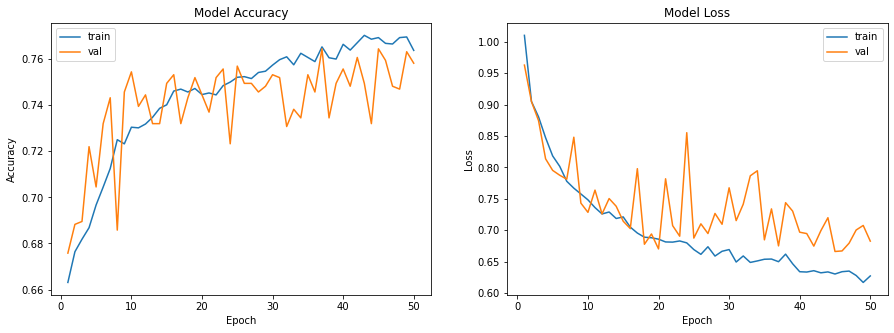

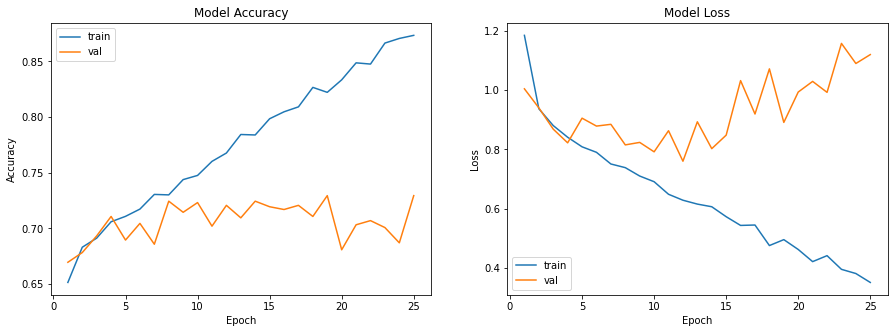

In [28]:
plot_model_history(cnn_history)
plot_model_history(ann_history)

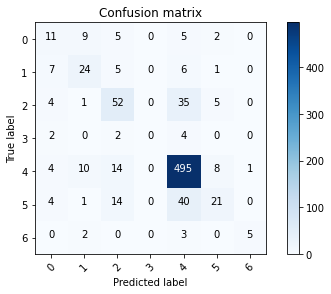

In [29]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


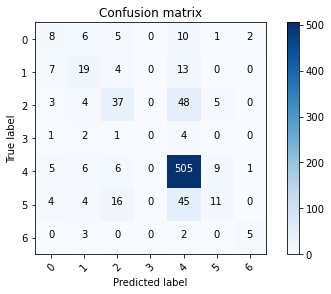

In [30]:
# Predict the values from the validation dataset
Y_ann_pred = ann_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_ann_pred_classes = np.argmax(Y_ann_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_ann_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx_ann = confusion_matrix(Y_ann_true, Y_ann_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_ann, classes = range(7)) 
